In [1]:
# General utils

import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import re
import tensorflow as tf

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 80)

2023-11-05 02:12:56.436394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("data/data_raw.csv",index_col=0)

In [3]:
df.shape

(2369, 15)

In [4]:
df.sample(5)

,Name,Number of Rating,Genre,Rating,Price,Description,Updated,Size,Installs,Current Version,Requires Android,Content Rating,Offered By,Interactive Elements,In-app Products
ID,,,,,,,,,,,,,,,
886,Baby Panda's Town: My Dream,"66,632",Educational,3.9,0,"Welcome to the Baby Panda's Town! At here, you...",07-Apr-22,154M,"10,000,000+",8.57.00.00,4.4 and up,Everyone,BabyBus,NaN,NaN
659,World Of Carrom :3D Board Game,"30,780",Sports,4.3,0,World of Carrom 3D is an easy-to-play multipla...,22-Mar-22,51M,"10,000,000+",4.7,4.4 and up,Everyone,AppOn Innovate,"Users Interact, In-Game Purchases",$0.99 - $45.99 per item
1146,ZOOKEEPER BATTLE,"54,333",Puzzle,4.1,0,We've reached and breached 10 million download...,23-Mar-22,57M,"1,000,000+",6.1.4,4.0.3 and up,"Everyone,Alcohol and Tobacco Reference",KITERETSU inc.,In-Game Purchases,$0.99 - $40.99 per item
312,Gravity Rider: Space Bike Race,"99,001",Racing,4.4,0,"Tackle moto racing trials, defeat your racing ...",08-Mar-22,70M,"10,000,000+",1.20.0,5.0 and up,Everyone,Vivid Games S.A.,Digital Purchases,$0.99 - $134.99 per item
580,Demon Hunter: Chronicles from Beyond (Full),"2,387",Adventure,4.4,$6.99,FANTASTIC HIDDEN OBJECT PUZZLE ADVENTURE GAME ...,21-Aug-19,53M,"10,000+",1.1,4.0.3 and up,"Teen,Violence, Blood",Artifex Mundi,Digital Purchases,$0.99 per item


In [5]:
# There are some nan values only in "Interactive Elements" and "In-app Products" columns which 
# actually means that there are no interactive elements or in-app products in the app.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2369 entries, 0 to 2368
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  2369 non-null   object 
 1   Number of Rating      2369 non-null   object 
 2   Genre                 2369 non-null   object 
 3   Rating                2369 non-null   float64
 4   Price                 2369 non-null   object 
 5   Description           2369 non-null   object 
 6   Updated               2369 non-null   object 
 7   Size                  2369 non-null   object 
 8   Installs              2369 non-null   object 
 9   Current Version       2369 non-null   object 
 10  Requires Android      2369 non-null   object 
 11  Content Rating        2369 non-null   object 
 12  Offered By            2369 non-null   object 
 13  Interactive Elements  1834 non-null   object 
 14  In-app Products       2136 non-null   object 
dtypes: float64(1), object

# Preprocessing

In [6]:
# Fix column names
def CamelCaseCols(df):
    cols = []
    for col in df.columns:
        col = col.lower()
        for punc in string.punctuation:
            col = col.replace(punc," ")
        col = col.split(" ")
        col = [i.capitalize() for i in col]
        col = "".join(col)
        cols.append(col)
    df.columns = cols
    return df

In [7]:
df = CamelCaseCols(df)
df.head(1)

,Name,NumberOfRating,Genre,Rating,Price,Description,Updated,Size,Installs,CurrentVersion,RequiresAndroid,ContentRating,OfferedBy,InteractiveElements,InAppProducts
ID,,,,,,,,,,,,,,,
0,Geometry Dash Lite,"7,227,039",Arcade,4.4,0,Jump and fly your way through danger in this r...,11-Dec-19,58M,"100,000,000+",2.2,4.0 and up,Everyone,RobTop Games,NaN,NaN


## Column by column

### - Name
Will directly go into Feature Engineering in NLP section

### - NumberOfRating (ordinal)
Removing ',' from 'NumberOfRating'

In [8]:
df.NumberOfRating = pd.to_numeric(df.NumberOfRating.str.replace("," , "")) 

However, since the number of votes will logically not meaningful if we want to use that model for dynamic prediction. It will be removed.

In [9]:
df.drop(columns="NumberOfRating", inplace=True)

### - Genre (nominal)
Will directly go into Feature Engineering

### - Rating (continous 1 decimal) 
Changing it's data type to numeric

In [10]:
df.loc[:,'Rating'] = pd.to_numeric(df.Rating)

### Price (intrinstically continous but can be converted into assumed as categorical because of low frequencies)
Removing '$' from 'Price'

Changing it's data type to numeric

In [11]:
df.loc[:,'Price'] = df.Price.str.replace("$" , "")
df.loc[:,'Price'] = pd.to_numeric(df.Price)

/var/folders/_l/048d7_xs4nq8m4g2753wq9bc0000gn/T/ipykernel_9918/1804471671.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.loc[:,'Price'] = df.Price.str.replace("$" , "")


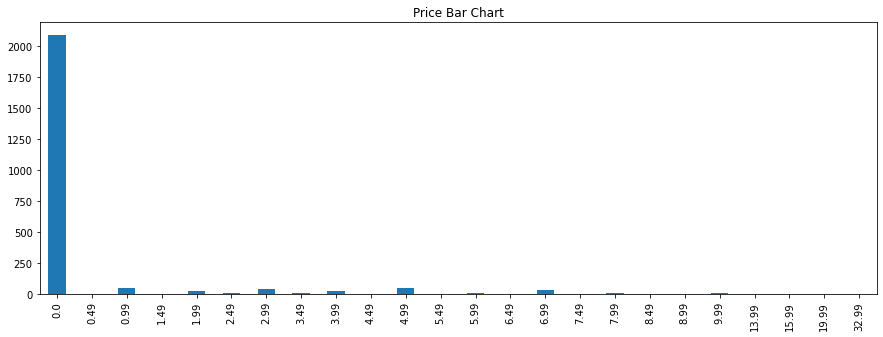

In [12]:
# sort by Price
df.loc[:,'Price'].value_counts().sort_index(ascending=True).plot(kind='bar',
                                                                 figsize=(15,5),
                                                                 title='Price Bar Chart');

### Description
Will directly go into Feature Engineering

### Updated
Changing it's data type to datetime

In [13]:
df.loc[:,'Updated'] = pd.to_datetime(df.Updated,format="%d-%b-%y")

### Size (ordinal)
Since the effect of the small size changes will be low, log base 2 of Installs are calculated instead of their original values 


In [14]:
def extract_number(str):
    match = re.search(r'\d+', str)
    if match:
        return int(match.group())
    else:
        return None

df.loc[:,'Size'] = df['Size'].apply(extract_number)
df['Size'].fillna(df['Size'].median(),inplace=True)

### Installs (ordinal)
Removing ',' and '+' from 'Installs'

In [15]:
df.loc[:,'Installs'] = pd.to_numeric(df.Installs.str.replace("," , "").str.replace("+" , ""))

/var/folders/_l/048d7_xs4nq8m4g2753wq9bc0000gn/T/ipykernel_9918/3975192161.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.loc[:,'Installs'] = pd.to_numeric(df.Installs.str.replace("," , "").str.replace("+" , ""))


### CurrentVersion
Will not be used in model 


In [16]:
df.drop(columns=["CurrentVersion"], inplace=True)
'''
df.loc[:,"Current_Version"]= df["Current_Version"].str[0:2] # Taking the first char of "Current_Version" Example of "Current_Version": 1.10.12
df.Current_Version.replace("Va","100000",inplace=True) # Unkown instance FLAGGED 
df.Current_Version.replace("A2","100000",inplace=True) # Unkown instance FLAGGED 
df.Current_Version.replace("v1","100000",inplace=True) # Unkown instance FLAGGED 
df.Current_Version = pd.to_numeric(df.Current_Version) # Changing it's data type to numeric
df.Current_Version.replace(100000,np.nan,inplace=True)
int_median = int(df.Current_Version.median())
df.Current_Version = np.clip(df.Current_Version,a_min=0,a_max=10) # clipping "Current_Version" between (0-20)
df.Current_Version.replace(np.nan,int_median,inplace=True) 
'''

'\ndf.loc[:,"Current_Version"]= df["Current_Version"].str[0:2] # Taking the first char of "Current_Version" Example of "Current_Version": 1.10.12\ndf.Current_Version.replace("Va","100000",inplace=True) # Unkown instance FLAGGED \ndf.Current_Version.replace("A2","100000",inplace=True) # Unkown instance FLAGGED \ndf.Current_Version.replace("v1","100000",inplace=True) # Unkown instance FLAGGED \ndf.Current_Version = pd.to_numeric(df.Current_Version) # Changing it\'s data type to numeric\ndf.Current_Version.replace(100000,np.nan,inplace=True)\nint_median = int(df.Current_Version.median())\ndf.Current_Version = np.clip(df.Current_Version,a_min=0,a_max=10) # clipping "Current_Version" between (0-20)\ndf.Current_Version.replace(np.nan,int_median,inplace=True) \n'

### RequiresAndroid


In [17]:
#df.loc[:,"RequiresAndroid"] = df.RequiresAndroid.str.replace(" and up" , "") # removing ' and up' from 'RequiresAndroid'
#df.RequiresAndroid = df.RequiresAndroid.str.replace("Varies with device" , "0") # changing 'Varies with device' to '0', 

In [18]:
df.loc[:,"RequiresAndroid"] = df.RequiresAndroid.str[0:3]

def remove_until_numeric(input_string):
    reversed_string = input_string[::-1]
    index_of_numeric = 0
    for char in reversed_string:
        if char.isdigit():
            break
        index_of_numeric += 1
    cleaned_reversed = ''.join(char for char in reversed_string[index_of_numeric:])
    result = cleaned_reversed[::-1]
    return result

df.loc[:,"RequiresAndroid"] = df.RequiresAndroid.apply(remove_until_numeric)
df.loc[df.RequiresAndroid=="", "RequiresAndroid"] = np.nan
df.RequiresAndroid = pd.to_numeric(df.RequiresAndroid)

In [19]:
# Filling the nans with median, acknowledging the leakage
df['RequiresAndroid'].fillna(df['RequiresAndroid'].median(),inplace=True)

### ContentRating (nominal)

In [20]:
df.ContentRating.replace(np.nan,"No Content",inplace=True)
df.ContentRating = df.ContentRating.apply(lambda x: re.sub(r'\s*,\s*', ',', x))
df.ContentRating = df.ContentRating.apply(lambda x: x.split(","))
df.ContentRating = df.ContentRating.apply(lambda x: len(x))

### OfferedBy (nominal)
Will directly go into Feature Engineering


### InteractiveElements
Some games includes more than one Interactive Element. Thus, column is preprocessed and splitted.

In [21]:
df.InteractiveElements.replace(np.nan,"No Element",inplace=True)
df.InteractiveElements = df.InteractiveElements.str.replace("Includes Random Items","").str.replace("(","").str.replace(")","").str.strip()
df.InteractiveElements = df.InteractiveElements.apply(lambda x: re.sub(r'\s*,\s*', ',', x))
df.InteractiveElements = df.InteractiveElements.apply(lambda x: x.split(","))

/var/folders/_l/048d7_xs4nq8m4g2753wq9bc0000gn/T/ipykernel_9918/2278779444.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.InteractiveElements = df.InteractiveElements.str.replace("Includes Random Items","").str.replace("(","").str.replace(")","").str.strip()


### InAppProducts

In [22]:
def extract_numbers(string):
    numbers = re.findall(r'\d+\.\d+', string)
    if numbers:
        first_num = float(numbers[0])
        last_num = float(numbers[-1])
        return pd.Series([first_num, last_num])
    else:
        return pd.Series([None, None])


In [23]:
df.loc[~df.InAppProducts.isna() ,["InAppProductsMin","InAppProductsMax"]] = df.loc[~df.InAppProducts.isna(), "InAppProducts"].apply(extract_numbers).values
df.loc[:, ["InAppProductsMin","InAppProductsMax"]] = df.loc[:, ["InAppProductsMin","InAppProductsMax"]].fillna(0)
df["InAppProductsMean"] = df.loc[:, ["InAppProductsMin","InAppProductsMax"]].mean(axis=1).values
df.loc[:, "InAppProductsBinary"] = df.InAppProducts.notnull().astype(int)
df.drop(columns=["InAppProducts"], inplace=True)


In [24]:
'''
# Name 
    # will directly go into Feature Engineering in NLP section

# NumberOfRating (Ordinal)
df.NumberOfRating = pd.to_numeric(df.NumberOfRating.str.replace("," , "")) # removing ',' from 'NumberOfRating'

# Genre (Nominal)
    # will directly go into Feature Engineering

# Rating (Continous 1 decimal) 
df.Rating = pd.to_numeric(df.Rating) # Changing it's data type to numeric

# Price (intrinstically continous but assumed as categorical because of low frequencies)
df.Price = df.Price.str.replace("$" , "") # removing '$' from 'Price'
df.Price = pd.to_numeric(df.Price) # Changing it's data type to numeric

# Description
    # will directly go into Feature Engineering

# Updated
df.Updated = pd.to_datetime(df.Updated,format="%d-%b-%y") # Changing it's data type to datetime

# Size (Ordinal)

def extract_number(str):
    match = re.search(r'\d+', str)
    if match:
        return int(match.group())
    else:
        return None

df['Size'] = df['Size'].apply(extract_number)
df['Size'].fillna(df['Size'].median(),inplace=True)
# Since the effect of the small size changes will be low, log base 2 of Installs are calculated instead of their original values 
df["Size"] = np.log2(df.Size)

# Installs (Ordinal)
df.Installs = pd.to_numeric(df.Installs.str.replace("," , "").str.replace("+" , "")) # removing ',' and '+' from 'Installs'

# Current_Version
    # Will not be used in model 
df.drop(columns=["Current_Version"], inplace=True)

#
# df.loc[:,"Current_Version"]= df["Current_Version"].str[0:2] # Taking the first char of "Current_Version" Example of "Current_Version": 1.10.12
# df.Current_Version.replace("Va","100000",inplace=True) # Unkown instance FLAGGED 
# df.Current_Version.replace("A2","100000",inplace=True) # Unkown instance FLAGGED 
# df.Current_Version.replace("v1","100000",inplace=True) # Unkown instance FLAGGED 
# df.Current_Version = pd.to_numeric(df.Current_Version) # Changing it's data type to numeric
# df.Current_Version.replace(100000,np.nan,inplace=True)
# int_median = int(df.Current_Version.median())
# df.Current_Version = np.clip(df.Current_Version,a_min=0,a_max=10) # clipping "Current_Version" between (0-20)
# df.Current_Version.replace(np.nan,int_median,inplace=True) 
#

# Requires_Android
#df.loc[:,"Requires_Android"] = df.Requires_Android.str.replace(" and up" , "") # removing ' and up' from 'Requires_Android'
#df.Requires_Android = df.Requires_Android.str.replace("Varies with device" , "0") # changing 'Varies with device' to '0', 
df.loc[:,"Requires_Android"]= df.Requires_Android.str[0:3]
df.loc[:,"Requires_Android"] = pd.to_numeric(df.Requires_Android.str.replace("Var" , "nan"), errors='coerce')
df['Requires_Android'].fillna(df['Requires_Android'].median(),inplace=True)

# Content_Rating (Nominal)
df.Content_Rating.replace(np.nan,"No Content",inplace=True)
df.Content_Rating = df.Content_Rating.apply(lambda x: re.sub(r'\s*,\s*', ',', x))
df.Content_Rating = df.Content_Rating.apply(lambda x: x.split(","))
df.Content_Rating = df.Content_Rating.apply(lambda x: len(x))

# Offered_By (Nominal)
    # will directly go into Feature Engineering

# Interactive_Elements 
df.Interactive_Elements.replace(np.nan,"No Element",inplace=True)
df.Interactive_Elements = df.Interactive_Elements.str.replace("Includes Random Items","").str.replace("(","").str.replace(")","").str.strip()
df.Interactive_Elements = df.Interactive_Elements.apply(lambda x: re.sub(r'\s*,\s*', ',', x))
df.Interactive_Elements = df.Interactive_Elements.apply(lambda x: x.split(","))

# In_app_Products

def extract_numbers(string):
    numbers = re.findall(r'\d+\.\d+', string)
    if numbers:
        first_num = float(numbers[0])
        last_num = float(numbers[-1])
        return pd.Series([first_num, last_num])
    else:
        return pd.Series([None, None])

df.In_app_Products = df.In_app_Products.fillna("0")
df[["In_app_Products_Min","In_app_Products_Max"]] = df.In_app_Products.apply(extract_numbers).values

df.In_app_Products = df.In_app_Products # removing ' and up' from 'Requires_Android'
df[~df.In_app_Products.isna()]["In_app_Products"]
df["In_app_Products"] = df["In_app_Products"].str.replace(' per item', '')
df.In_app_Products.fillna(0,inplace=True) # Filling unknows with median
'''

'\n# Name \n    # will directly go into Feature Engineering in NLP section\n\n# NumberOfRating (Ordinal)\ndf.NumberOfRating = pd.to_numeric(df.NumberOfRating.str.replace("," , "")) # removing \',\' from \'NumberOfRating\'\n\n# Genre (Nominal)\n    # will directly go into Feature Engineering\n\n# Rating (Continous 1 decimal) \ndf.Rating = pd.to_numeric(df.Rating) # Changing it\'s data type to numeric\n\n# Price (intrinstically continous but assumed as categorical because of low frequencies)\ndf.Price = df.Price.str.replace("$" , "") # removing \'$\' from \'Price\'\ndf.Price = pd.to_numeric(df.Price) # Changing it\'s data type to numeric\n\n# Description\n    # will directly go into Feature Engineering\n\n# Updated\ndf.Updated = pd.to_datetime(df.Updated,format="%d-%b-%y") # Changing it\'s data type to datetime\n\n# Size (Ordinal)\n\ndef extract_number(str):\n    match = re.search(r\'\\d+\', str)\n    if match:\n        return int(match.group())\n    else:\n        return None\n\ndf[\'Si

In [25]:
df.head(2)

,Name,Genre,Rating,Price,Description,Updated,Size,Installs,RequiresAndroid,ContentRating,OfferedBy,InteractiveElements,InAppProductsMin,InAppProductsMax,InAppProductsMean,InAppProductsBinary
ID,,,,,,,,,,,,,,,,
0,Geometry Dash Lite,Arcade,4.4,0.0,Jump and fly your way through danger in this r...,2019-12-11,58.0,100000000,4.0,1,RobTop Games,[No Element],0.00,0.00,0.00,0
1,Fastlane: Road to Revenge,Action,4.6,0.0,THEY TOOK YOUR CITY. THEY SHOULD’VE TAKEN YOUR...,2021-08-16,92.0,10000000,4.4,2,Space Ape,[Digital Purchases],0.99,99.99,50.49,1


## Creating Target Variable

Instead of taking **Rating** or **Installs** as one target variable we created a combination of those two. Because there is excessive gap between Installs we concluded that taking log of Installs 

In [26]:
df.Rating.min() , df.Rating.max()

(2.2, 5.0)

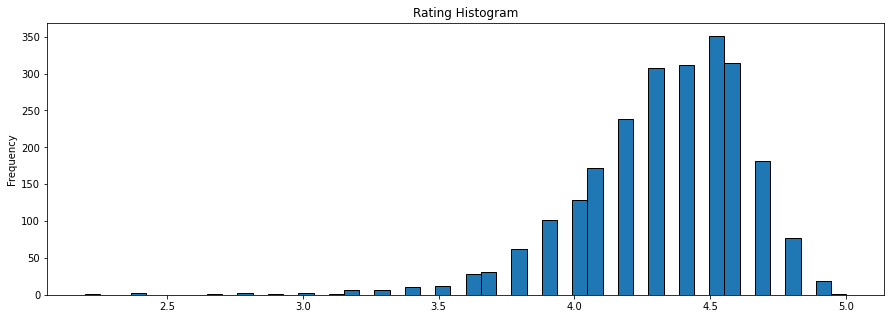

In [27]:
df.Rating.plot.hist(bins=50,figsize=(15,5),title='Rating Histogram',edgecolor='black');

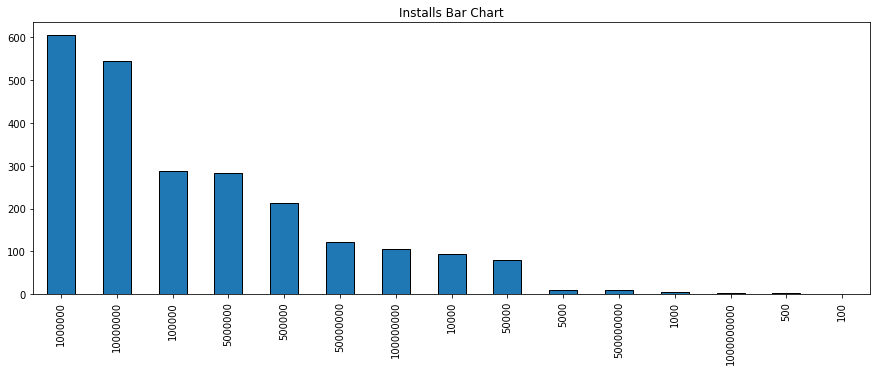

In [28]:
df.Installs.value_counts().plot.bar(figsize=(15,5),title='Installs Bar Chart',edgecolor='black');

In [29]:
df[["Rating","Installs"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,2369.0,4.326931e+00,3.132233e-01,2.2,4.2,4.4,4.5,5.000000e+00
Installs,2369.0,1.339188e+07,5.134385e+07,100.0,500000.0,1000000.0,10000000.0,1.000000e+09


### Crafting the target variable

count    2369.000000
mean       26.907264
std         4.923225
min         6.600000
25%        23.935674
50%        27.000000
75%        30.800000
max        41.400000
dtype: float64

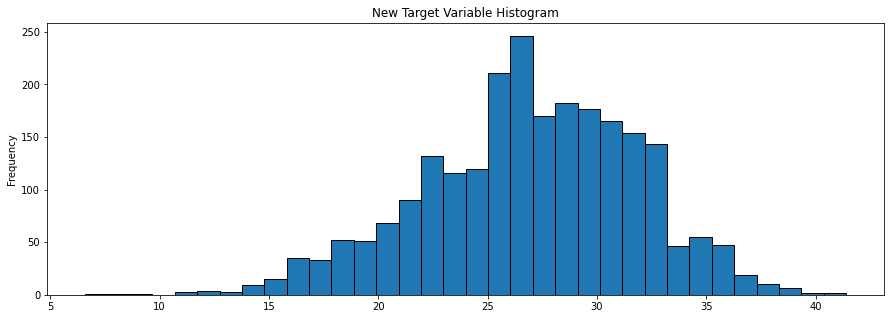

In [30]:
new_target_var = (df.Rating.values*np.log10(df.Installs.values))
new_target_var = pd.Series(new_target_var)
new_target_var.plot.hist(bins=34,figsize=(15,5),title='New Target Variable Histogram',edgecolor='black');
display(new_target_var.describe())

In [31]:
df.loc[:, "Target"] = new_target_var # Target Created
df.drop(columns=["Rating","Installs"],inplace=True)

## Image Preprocessing

In [32]:
import os
import PIL
from PIL import Image
import pathlib

path_W = os.getcwd()+"\\data\\icon_png\\"
path_MACOS = os.path.dirname(os.getcwd())+'/icon_png/'

image_list = os.listdir(path_MACOS)
full_paths = [path_MACOS+x for x in image_list]

only_nums = [int(x.replace(".png","")) for x in image_list]
only_nums = np.array(only_nums) # converted to np.array

In [33]:
dictt = {
    "index":only_nums,
    "full_paths": full_paths
}
image_df = pd.DataFrame(dictt)
image_df = image_df.sort_values(by="index",ascending=True).reset_index(drop=True)
image_df.drop(columns=["index"],inplace=True)

### Control

**Does index of main dataframe matches with image dataframe?**

--------------------------------------------------
Name of the game is:  SNIPER FURY: SHOOTING GAME


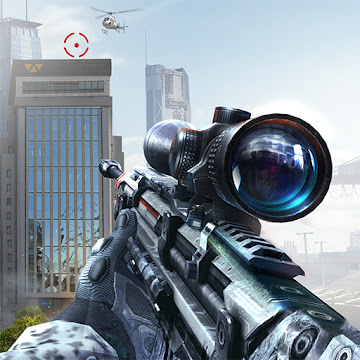

In [34]:
# input 15 for a clear understanding
index = int(input("Write an index from 0 to 2968: " ))
print("-"*50)
print("Name of the game is: ",df.loc[index,"Name"].upper())
PIL.Image.open(image_df.loc[index,"full_paths"])

In [35]:
### Image Representations from Pre-trained model
# (Further Improvement)
'''
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch

pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 8
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  # Taking the vector instead of captions
  output_ids = model.generate(pixel_values, **gen_kwargs)

  # preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  # preds = [pred.strip() for pred in preds]
  return output_ids
  '''

'\nfrom transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer\nimport torch\n\npip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118\ntorch.device("cuda" if torch.cuda.is_available() else "cpu")\n\nmodel = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")\nfeature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")\ntokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel.to(device)\n\nmax_length = 8\nnum_beams = 4\ngen_kwargs = {"max_length": max_length, "num_beams": num_beams}\ndef predict_step(image_paths):\n  images = []\n  for image_path in image_paths:\n    i_image = Image.open(image_path)\n    if i_image.mode != "RGB":\n      i_image = i_image.convert(mode="RGB")\n\n    images.append(i_image)\n\n  pixel_values = feature_extractor(images=images, ret

# Train - Test - Validation Split
Split needed before feature engineering to prevent leakage

In [36]:
np.random.seed(42)
ids = df.index.to_numpy()
test_ids = np.random.choice(ids, int(len(ids)*0.2))
val_ids = np.random.choice(list(set(ids)-set(test_ids)), int(len(ids)*0.10))
train_ids = np.array(list(set(ids)-set(test_ids)-set(val_ids)))

print(f"train_ids: {len(train_ids)}")
print(f"test_ids: {len(test_ids)}")
print(f"val_ids: {len(val_ids)}")

train_ids: 1731
test_ids: 473
val_ids: 236


In [37]:
# Save the index for further use
import pickle

split_dict = {'train': train_ids, 
              'test': test_ids,
              'val': val_ids}

# dump split_dict
with open('data/split_dict.pkl', 'wb') as f:
    pickle.dump(split_dict, f)

# Manipulation & Feature Engineering

In [38]:
df.sample(2)

,Name,Genre,Price,Description,Updated,Size,RequiresAndroid,ContentRating,OfferedBy,InteractiveElements,InAppProductsMin,InAppProductsMax,InAppProductsMean,InAppProductsBinary,Target
ID,,,,,,,,,,,,,,,
1241,Fairway Solitaire - Card Game,Card,0.0,"Set course for the fairways🏌🏽of the world, but...",2021-12-06,93.0,4.4,1,Big Fish Games,[Digital Purchases],0.99,119.99,60.49,1,30.815262
203,Smashy Drift Racing,Racing,0.0,Get ready to drive legendary cars! Welcome to ...,2019-11-19,57.0,4.4,2,AKPublish pty ltd,[Digital Purchases],1.99,19.99,10.99,1,23.400000


## Column by colum

* Columns that includes text (Name and Description) will be processed in the 'NLP Model' Notebook

### Name
lenght and avg. num. of charachters in created. 

In [39]:
def fe_Name(str_):
    str_ = str_.translate(str.maketrans('', '', string.punctuation))
    splitted = str_.split()
    
    len_of_words = len(splitted)
    chars = []
    for word in splitted:
        chars.append(len(word))
    avr_chars = np.array(chars).mean()
    return pd.Series([len_of_words, avr_chars])

df[["NumOfWord","AvgNumOfChars"]] = df.Name.apply(fe_Name)

### Genre

In [40]:
df["Genre"].value_counts()

Puzzle          250
Action          247
Role Playing    232
Adventure       207
Strategy        189
Casual          174
Educational     166
Simulation      150
Arcade          135
Sports          130
Card            109
Racing          107
Word             83
Board            72
Casino           50
Music            48
Trivia           20
Name: Genre, dtype: int64

In [41]:
Genre_df = pd.get_dummies(df["Genre"], drop_first=True)
Genre_df = CamelCaseCols(Genre_df)
GenreCols = Genre_df.columns.tolist()

In [42]:
df = pd.concat([df,Genre_df], axis=1)

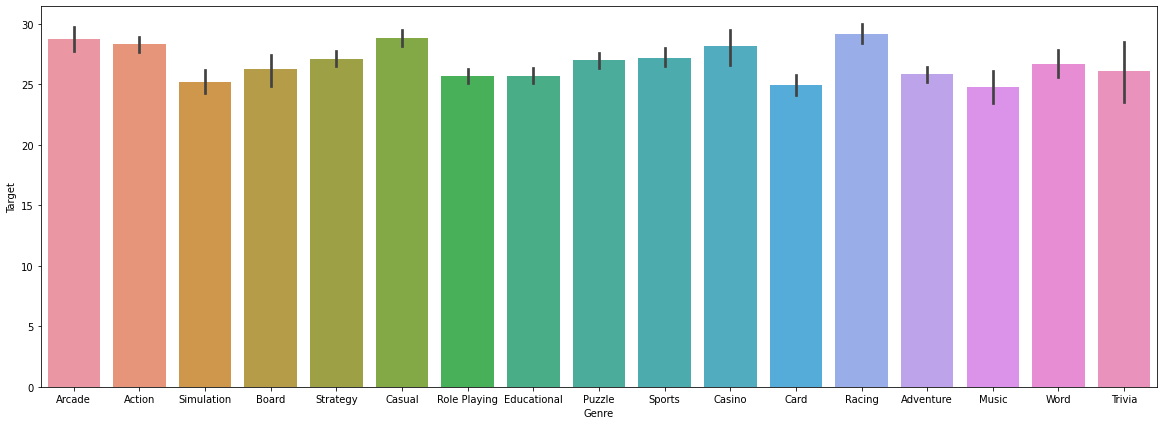

In [43]:
plt.figure(figsize=(20,7))
sns.barplot(data=df , x="Genre",y="Target");

In [44]:
df.drop(columns=["Genre"], inplace=True)

### Interactive_Elements
Some of the instances consists of multiple 'Interactive Elements'. MultiLabelBinarizer used to asses every Interactive_Elements as a feature


In [45]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
ie_cols = pd.DataFrame(mlb.fit_transform(df['InteractiveElements']), columns=mlb.classes_, index=df.index)
ie_cols = CamelCaseCols(ie_cols)
display(ie_cols.head(2))
df = pd.concat([df,ie_cols], axis=1)
df.drop(columns=["InteractiveElements","NoElement"], inplace=True)

,DigitalPurchases,InAppPurchases,InGamePurchases,NoElement,SharesInfo,SharesLocation,UsersInteract
ID,,,,,,,
0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0


### LastUpdate
Days passed from last update, also transforming it with Ln because of the big gap

In [46]:
# Last Update
scraping_day = pd.Timestamp(2022, 5, 29)
df["LastUpdate"] = (scraping_day - df.Updated).dt.days
df["LastUpdateLn"] = np.log(df.LastUpdate)

### OfferdBy
Top 10 of the most frequent Companies are selected, other ones labeled as 'Other'

In [47]:
top10D = df["OfferedBy"].value_counts()[:12].index.tolist()
df["OfferedBy"] = df["OfferedBy"].apply(lambda x: x if x in top10D else "Other")

In [49]:
OfferedBy_df = pd.get_dummies(df["OfferedBy"], drop_first=True)
OfferedBy_df = CamelCaseCols(OfferedBy_df)
OfferedByCols = OfferedBy_df.columns.tolist()

In [51]:
df = pd.concat([df,OfferedBy_df], axis=1)

<AxesSubplot:title={'center':'OfferedBy Bar Chart'}, xlabel='OfferedBy'>

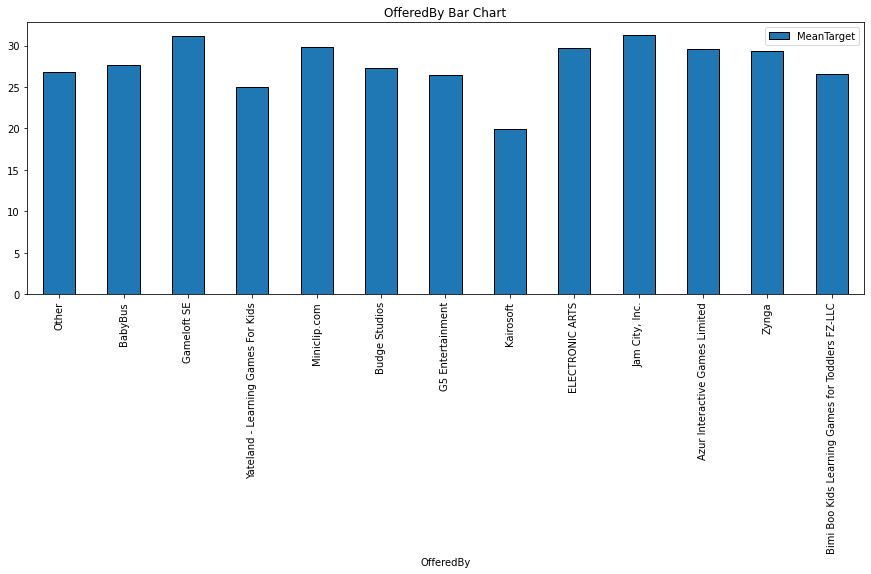

In [52]:
df.groupby(by=df["OfferedBy"]).agg(
    MeanTarget=("Target","mean"),
    Count=("Target","count")
).reset_index().sort_values(by="Count",ascending=False).plot.\
bar(x="OfferedBy",y="MeanTarget",figsize=(15,5),title='OfferedBy Bar Chart',edgecolor='black')

In [53]:
df.drop(columns=["OfferedBy"], inplace=True)

### InAppProducts
Maximum, minimum, and mean of the in app products prices calculated as new features

In [54]:
df.InAppProductsMin.fillna(0,inplace=True)
df.InAppProductsMax.fillna(0,inplace=True)
df.InAppProductsMean.fillna(0,inplace=True)

### Price
Prices are segmented

In [55]:
df["FreeOrNot"] = np.nan
df["PriceSegment"] = np.nan
for idx,item in df.Price.iteritems():
    # Free_or_Not
    if item>0:
        df.loc[idx,"FreeOrNot"] = 0 # not free
    else:
        df.loc[idx,"FreeOrNot"] = 1 # free
    
    # Segments (handcrafted)
    if item==0:
        df.loc[idx,"PriceSegment"] = 0
    elif item <= 6:
        df.loc[idx,"PriceSegment"] = 1
    elif item <= 26:
        df.loc[idx,"PriceSegment"] = 2
    elif item > 26:
        df.loc[idx,"PriceSegment"] = 3

### Size
Since the effect of the small size changes will be low, log base 2 of Installs are calculated instead of their original values.


In [56]:
df.Size

ID
0        58.0
1        92.0
2        40.0
3        80.0
4       148.0
        ...  
2364     79.0
2365     74.0
2366    144.0
2367     87.0
2368    189.0
Name: Size, Length: 2369, dtype: float64

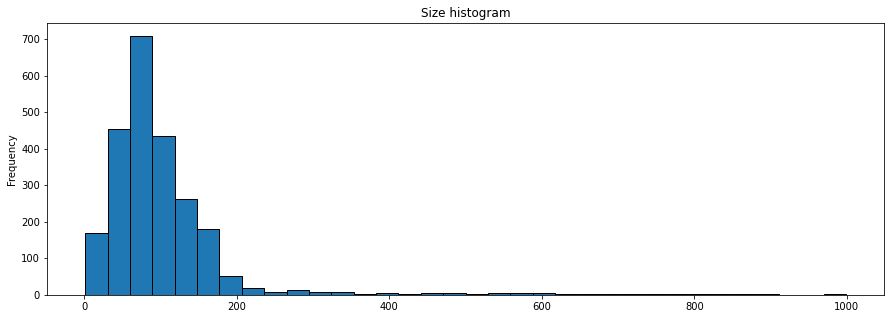

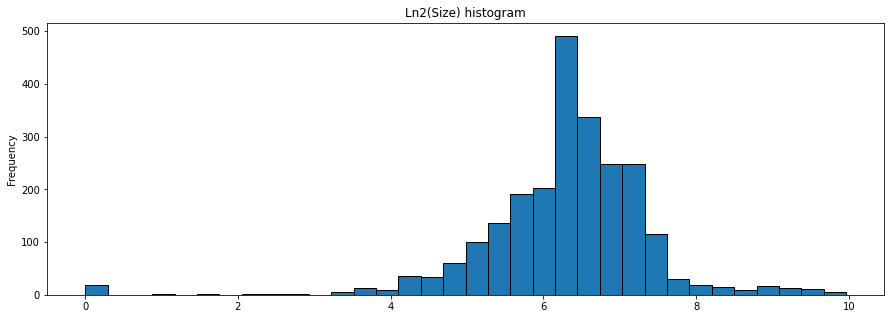

In [57]:
df["Size"].plot.hist(bins=34,figsize=(15,5),title='Size histogram',edgecolor='black')
plt.show()
df["SizeLn2"] = np.log2(df.Size)
df["SizeLn2"].plot.hist(bins=34,figsize=(15,5),title='Ln2(Size) histogram',edgecolor='black');

In [58]:
# df["Size"] = np.log2(df.Size)

In [59]:
# Taking RGB means as a feature

df[["Rmean","Gmean","Bmean"]] = np.nan
df[["Rstd","Gstd","Bstd"]] = np.nan

for idx in image_df.index:
    current_image = PIL.Image.open(image_df.loc[idx,"full_paths"])
    arr = np.array(current_image)
    c_RGB_mean = np.mean(arr,axis=(0,1))
    df.loc[idx , ["Rmean","Gmean","Bmean"]] = c_RGB_mean

    c_RGB_std = np.std(arr,axis=(0,1))
    df.loc[idx , ["Rstd","Gstd","Bstd"]] = c_RGB_std

In [60]:
'''
# Name
def fe_Name(str_):
    str_ = str_.translate(str.maketrans('', '', string.punctuation))
    splitted = str_.split()
    
    len_of_words = len(splitted)
    chars = []
    for word in splitted:
        chars.append(len(word))
    avr_chars = np.array(chars).mean()
    return pd.Series([len_of_words, avr_chars])

df[["num_of_word","avg_num_of_chars"]] = df.Name.apply(fe_Name)

# Interactive_Elements
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
ie_labels = pd.DataFrame(mlb.fit_transform(df['Interactive_Elements']), columns=mlb.classes_, index=df.index)
df = pd.concat([df,ie_labels], axis=1)
df.drop(columns=["No Element"], inplace=True)

# last_update
scraping_day = pd.Timestamp(2022, 5, 29)
df["last_update"] = (scraping_day - df.Updated).dt.days
df["last_update_ln"] = np.log(df.last_update)

# In_app_Products
# Maximum, minimum, and mean of the in app products prices calculated as new features
df["In_app_Products_Mean"] = (df["In_app_Products_Max"] - df["In_app_Products_Min"]) / 2
df.In_app_Products_Min.fillna(0,inplace=True)
df.In_app_Products_Max.fillna(0,inplace=True)
df.In_app_Products_Mean.fillna(0,inplace=True)

# Price
# Prices are segmented
df["Free_or_Not"] = np.nan
df["Price_Segment"] = np.nan
for idx,item in df.Price.iteritems():
    # Free_or_Not
    if item>0:
        df.loc[idx,"Free_or_Not"] = 0 # not free
    else:
        df.loc[idx,"Free_or_Not"] = 1 # free
    
    # Segment
    if item==0:
        df.loc[idx,"Price_Segment"] = 0
    elif item <= 6:
        df.loc[idx,"Price_Segment"] = 1
    elif item <= 26:
        df.loc[idx,"Price_Segment"] = 2
    elif item > 26:
        df.loc[idx,"Price_Segment"] = 3

# Taking RGB means as a feature

df[["R_mean","G_mean","B_mean"]] = np.nan
df[["R_std","G_std","B_std"]] = np.nan

for idx in image_df.index:
    current_image = PIL.Image.open(image_df.loc[idx,"full_paths"])
    arr = np.array(current_image)
    c_RGB_mean = np.mean(arr,axis=(0,1))
    df.loc[idx , ["R_mean","G_mean","B_mean"]] = c_RGB_mean

    c_RGB_std = np.std(arr,axis=(0,1))
    df.loc[idx , ["R_std","G_std","B_std"]] = c_RGB_std

'''

'\n# Name\ndef fe_Name(str_):\n    str_ = str_.translate(str.maketrans(\'\', \'\', string.punctuation))\n    splitted = str_.split()\n    \n    len_of_words = len(splitted)\n    chars = []\n    for word in splitted:\n        chars.append(len(word))\n    avr_chars = np.array(chars).mean()\n    return pd.Series([len_of_words, avr_chars])\n\ndf[["num_of_word","avg_num_of_chars"]] = df.Name.apply(fe_Name)\n\n# Interactive_Elements\nfrom sklearn.preprocessing import MultiLabelBinarizer\nmlb = MultiLabelBinarizer()\nie_labels = pd.DataFrame(mlb.fit_transform(df[\'Interactive_Elements\']), columns=mlb.classes_, index=df.index)\ndf = pd.concat([df,ie_labels], axis=1)\ndf.drop(columns=["No Element"], inplace=True)\n\n# last_update\nscraping_day = pd.Timestamp(2022, 5, 29)\ndf["last_update"] = (scraping_day - df.Updated).dt.days\ndf["last_update_ln"] = np.log(df.last_update)\n\n# In_app_Products\n# Maximum, minimum, and mean of the in app products prices calculated as new features\ndf["In_app_Pr

# Exploratory Data Analysis

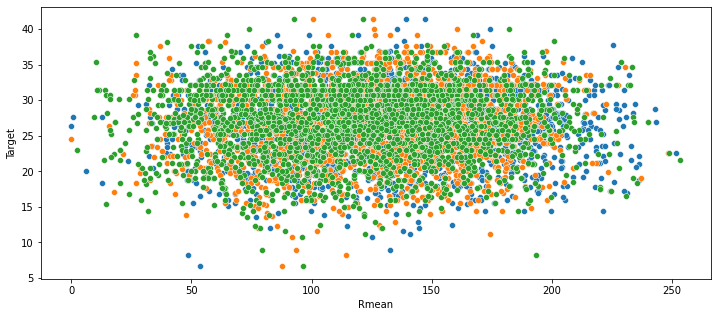

In [61]:
df[["Rmean","Gmean","Bmean","Target"]].corr()[["Target"]] 
plt.figure(figsize=(12,5))
sns.scatterplot(data=df,x="Rmean",y="Target",palette="green");
sns.scatterplot(data=df,x="Gmean",y="Target",palette="green");
sns.scatterplot(data=df,x="Bmean",y="Target",palette="green");
# Not much correlation between target

There is a clear negative correlation between price segment and target which means as the game becomes expensive it preffered less 

,Target
PriceSegment,
0.0,27.723337
1.0,21.300984
2.0,19.764045
3.0,13.686189


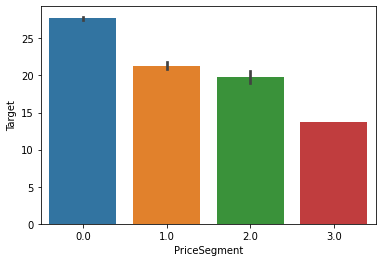

In [62]:
display(df.groupby(by="PriceSegment").mean()[["Target"]])
sns.barplot(data=df,x="PriceSegment",y="Target");

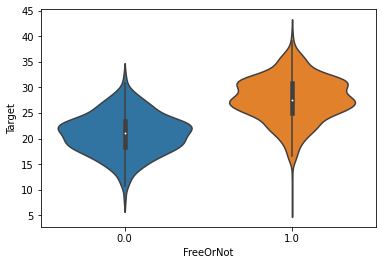

In [63]:
sns.violinplot(data=df, x="FreeOrNot", y="Target");

In [64]:
df.sample(5)

,Name,Price,Description,Updated,Size,RequiresAndroid,ContentRating,InAppProductsMin,InAppProductsMax,InAppProductsMean,InAppProductsBinary,Target,NumOfWord,AvgNumOfChars,Adventure,Arcade,Board,Card,Casino,Casual,Educational,Music,Puzzle,Racing,RolePlaying,Simulation,Sports,Strategy,Trivia,Word,DigitalPurchases,InAppPurchases,InGamePurchases,SharesInfo,SharesLocation,UsersInteract,LastUpdate,LastUpdateLn,Babybus,BimiBooKidsLearningGamesForToddlersFzLlc,BudgeStudios,ElectronicArts,G5Entertainment,GameloftSe,JamCityInc,Kairosoft,MiniclipCom,Other,YatelandLearningGamesForKids,Zynga,FreeOrNot,PriceSegment,SizeLn2,Rmean,Gmean,Bmean,Rstd,Gstd,Bstd
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
787,Airport City transport manager,0.0,"""Airport games are a wonderful adventure, and ...",2022-03-24,176.0,5.0,1,0.25,119.99,60.12,1,27.3,4.0,6.75,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,66,4.189655,0,0,0,0,0,0,0,0,0,1,0,0,1.0,0.0,7.459432,123.860270,127.001829,122.903866,46.310963,41.841635,45.982088
2005,infinite heroes:ldle RPG Game,0.0,A mobile Idle RPG with a huge variety of war m...,2022-03-31,185.0,4.4,3,0.99,99.99,50.49,1,23.5,4.0,6.25,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,59,4.077537,0,0,0,0,0,0,0,0,0,1,0,0,1.0,0.0,7.531381,83.074159,110.547292,72.422384,65.244920,69.429763,62.337371
471,The Walking Dead: Season One,0.0,"As featured in TegraZone, The Walking Dead is ...",2018-03-06,12.0,2.3,6,4.99,14.99,9.99,1,32.2,5.0,4.60,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1545,7.342779,0,0,0,0,0,0,0,0,0,1,0,0,1.0,0.0,3.584963,128.256119,93.251458,65.050054,70.237723,68.292399,67.177760
776,Streetball Allstar,0.0,We are an exciting and fast-paced multiplayer ...,2022-04-05,90.0,5.0,2,0.99,99.99,50.49,1,26.4,2.0,8.50,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,54,3.988984,0,0,0,0,0,0,0,0,0,1,0,0,1.0,0.0,6.491853,107.108912,74.024931,106.632353,81.780267,76.942343,84.223441
2271,Baby Panda's Safety & Habits,0.0,Baby Panda's Safety & Habits helps kids develo...,2021-12-23,163.0,4.4,1,0.99,0.99,0.99,1,28.0,4.0,5.50,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,157,5.056246,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,7.348728,190.398665,165.191906,112.517029,87.075461,80.654888,102.088095


In [71]:
df.columns = [i+"IE" if i in ie_cols else i for i in df.columns]
df.columns = [i+"OB" if i in OfferedByCols else i for i in df.columns]
df.columns = [i+"G" if i in GenreCols else i for i in df.columns]

In [72]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

In [73]:
df.to_csv("data/data_pp.csv")